# Dataset Collection

Searched for the existing dataset and found nothing much.Finally, images of words are downloaded manually one by one from 1-50 digit words. There are 10-20 images in each class stored in different folders withing a directory.
    


In [5]:
import pandas as pd
import os
import random
import PIL
import cv2
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Data Augmentation Code

This process effectively increases the size of the dataset by creating multiple variations of each original image through random transformations. These variations help in improving the model's robustness and generalization capabilities during training.

In [7]:
# Define directories
input_dir = "Dataset"
output_dir = "augmented_dataset"

# Defining data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate through each folder in the input directory
for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    
    # Create a subdirectory in the output directory for the current folder
    output_folder_path = os.path.join(output_dir, folder)
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)
    
    # Iterate through each image in the folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        
        # Load the image
        try: 
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Generate augmented images
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder_path, save_prefix='aug', save_format='jpg'):
                i += 1
                if i >= 5:  # Generate 5 augmented images per original image
                    break
        except:
            continue


In [8]:
root="augmented_dataset"
classes=os.listdir(root)

In [47]:
X=[]
y=[]

for cls in classes:
    class_dir=os.path.join(root,cls)
    images=os.listdir(class_dir)
    for image in images:
        path=os.path.join(class_dir,image)
        img=cv2.imread(path)
        
        try:
            resized_img=cv2.resize(img,(256,256))
            X.append([resized_img])
            y.append(cls)
        except:
            continue

In [10]:
len(X),len(y)

(3936, 3936)

# Data preprocessing

In [13]:
X = np.array(X).reshape(-1, 256, 256, 3)
X=np.array(X)
X = X.astype('float32')
X /= 255

In [48]:
y

['eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eight',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 'eighteen',
 '

In [49]:
le=LabelEncoder()
y=le.fit_transform(y)
Y = to_categorical(y, 50)

In [50]:
y,le.fit

array([ 0,  0,  0, ..., 49, 49, 49], dtype=int64)

In [17]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

# Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state =21)

In [19]:
batch_size = 32
img_shape = (256, 256, 3)

In [20]:
len(X_train),len(y_train)

(3148, 3148)

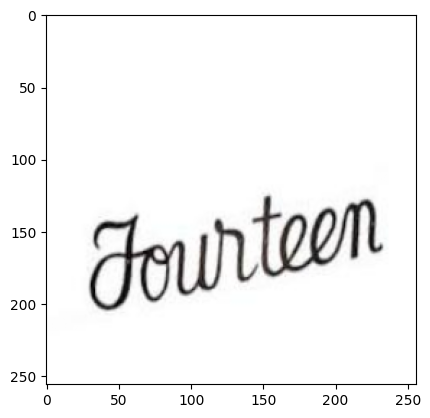

In [30]:
plt.imshow(X_train[5])

In [21]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

# Model Experiment

1. Transfer learning (Xception Net)
2. CNN Model


## Xception Net

In [25]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(50,activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
Total params: 21936218 (83.68 MB)
Trainable params: 1074738 (4.10 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [26]:
with open('xception_model_summary.txt', 'w') as f:
        xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 50)                25650     
                                                                 
Total params: 21936218 (83.68 MB)
Trainable params: 1074738 (4.10 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [27]:
xception_model.fit(X_train, y_train, epochs = 30, verbose = 1,validation_data=(X_test,y_test))

Epoch 1/30
99/99 [==============================] - 355s 4s/step - loss: 3.5397 - accuracy: 0.1226 - val_loss: 3.0816 - val_accuracy: 0.2145
Epoch 2/30
99/99 [==============================] - 367s 4s/step - loss: 2.5511 - accuracy: 0.3447 - val_loss: 2.6514 - val_accuracy: 0.2995
Epoch 3/30
99/99 [==============================] - 366s 4s/step - loss: 1.9465 - accuracy: 0.4968 - val_loss: 2.2927 - val_accuracy: 0.3744
Epoch 4/30
99/99 [==============================] - 354s 4s/step - loss: 1.5229 - accuracy: 0.6058 - val_loss: 2.0359 - val_accuracy: 0.4581
Epoch 5/30
99/99 [==============================] - 352s 4s/step - loss: 1.2203 - accuracy: 0.6896 - val_loss: 1.8658 - val_accuracy: 0.4962
Epoch 6/30
99/99 [==============================] - 353s 4s/step - loss: 0.9745 - accuracy: 0.7614 - val_loss: 1.7444 - val_accuracy: 0.5190
Epoch 7/30
99/99 [==============================] - 350s 4s/step - loss: 0.8141 - accuracy: 0.8043 - val_loss: 1.6210 - val_accuracy: 0.5609
Epoch 8/30
99

In [28]:
loss, accuracy = xception_model.evaluate(X_test, y_test)
print(accuracy)

25/25 [==============================] - 69s 3s/step - loss: 1.6387 - accuracy: 0.6358
0.6357868313789368


In [29]:
loss, accuracy = xception_model.evaluate(X_train, y_train)
print(accuracy)

99/99 [==============================] - 272s 3s/step - loss: 0.0471 - accuracy: 0.9924
0.9923760890960693


### Prediction

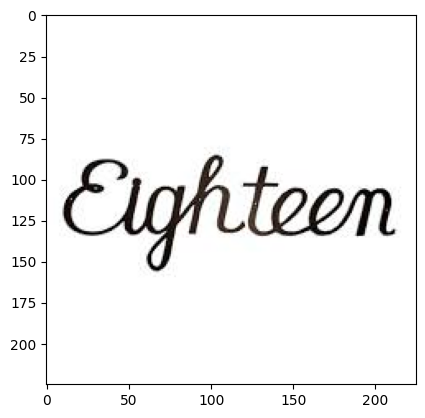

In [41]:
test=[]
image="eighteen.jpg"
img=cv2.imread(image)
# print(img)
plt.imshow(img)

resized_img=cv2.resize(img,(256,256))
test.append(resized_img)

test=np.array(test).reshape(-1,256,256,3)
test=np.array(test)
test= test.astype('float32')
test/=255

In [45]:
pred=np.argmax(xception_model.predict(test))
res=le.inverse_transform([pred])
print (res)

1/1 [==============================] - 0s 110ms/step
1
[1]


In [22]:
import pickle

with open("xception-model.pkl","wb") as f:
    pickle.dump(xception_model,f)

with open("label_encoder.pkl","wb") as f:
    pickle.dump(le,f)

# CNN 


In [20]:
model2=Sequential()
model2.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(256,256,3), activation='relu',))
model2.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())


model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model2.add(BatchNormalization())
          
model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model2.add(Flatten())

model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(50, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
model2.fit(X_train, y_train, epochs = 30, verbose = 1,validation_data=(X_test,y_test))

Epoch 1/30
42/42 [==============================] - 232s 5s/step - loss: 3.6025 - accuracy: 0.0622 - val_loss: 3.2963 - val_accuracy: 0.0419
Epoch 2/30
42/42 [==============================] - 219s 5s/step - loss: 3.1215 - accuracy: 0.0975 - val_loss: 3.2832 - val_accuracy: 0.0299
Epoch 3/30
42/42 [==============================] - 227s 5s/step - loss: 2.9711 - accuracy: 0.1319 - val_loss: 3.2564 - val_accuracy: 0.0719
Epoch 4/30
42/42 [==============================] - 214s 5s/step - loss: 2.7545 - accuracy: 0.2039 - val_loss: 3.4733 - val_accuracy: 0.0599
Epoch 5/30
42/42 [==============================] - 204s 5s/step - loss: 2.7046 - accuracy: 0.1844 - val_loss: 3.3331 - val_accuracy: 0.0689
Epoch 6/30
42/42 [==============================] - 220s 5s/step - loss: 2.5669 - accuracy: 0.2196 - val_loss: 3.1572 - val_accuracy: 0.0689
Epoch 7/30
42/42 [==============================] - 233s 6s/step - loss: 2.3987 - accuracy: 0.2684 - val_loss: 3.1069 - val_accuracy: 0.0988
Epoch 8/30
42

In [29]:
with open('cnn_model_summary.txt', 'w') as f:
        model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 127, 127, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                      

In [22]:
model2.history.history

{'loss': [3.6025197505950928,
  3.1214568614959717,
  2.9710888862609863,
  2.754503011703491,
  2.704561948776245,
  2.566859245300293,
  2.3987138271331787,
  2.2225100994110107,
  2.1150155067443848,
  1.945818543434143,
  1.768913984298706,
  1.6429234743118286,
  1.4693621397018433,
  1.2681039571762085,
  1.1980243921279907,
  1.030888319015503,
  0.9038716554641724,
  0.8025956749916077,
  0.7096052765846252,
  0.611102819442749,
  0.5034343004226685,
  0.4467656910419464,
  0.4081980884075165,
  0.32994163036346436,
  0.2815946340560913,
  0.25732406973838806,
  0.21609164774417877,
  0.18213802576065063,
  0.16089114546775818,
  0.14499437808990479],
 'accuracy': [0.062218889594078064,
  0.09745127707719803,
  0.1319340318441391,
  0.20389805734157562,
  0.1844078004360199,
  0.21964018046855927,
  0.2683658301830292,
  0.319340318441391,
  0.3658170998096466,
  0.40704646706581116,
  0.4715142548084259,
  0.5157421231269836,
  0.5854572653770447,
  0.6619190573692322,
  0.671

In [26]:
summary = pd.DataFrame(model2.history.history)
summary.head(15)
summary.to_csv("cnn.csv", index=False)

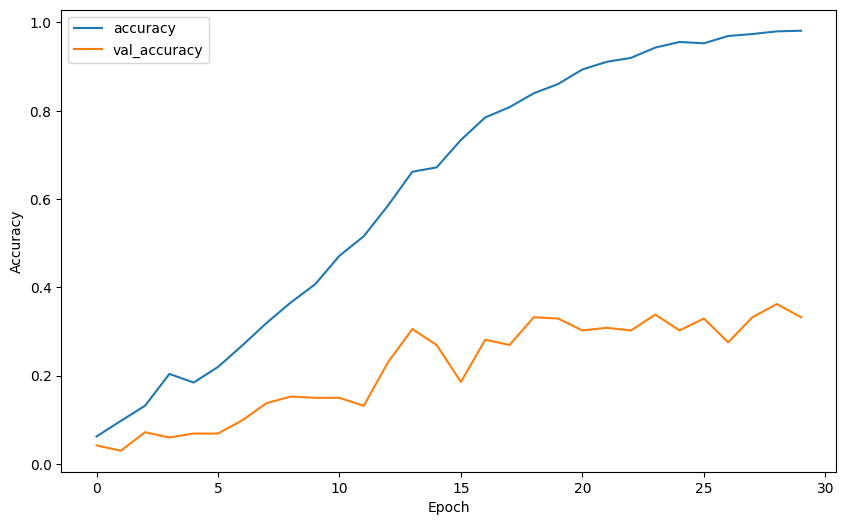

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()
plt.savefig("accuracy.png")

Initially I have trained XceptionNet, ResNet,VCG-16 and CNN on my dataset of (336 images). All the models were overfitting and even in that Xception Network gave me the better results out of all these models.

So, i have used data augmentation to generate more data so that overfitting can be reduced and I went ahead had trained the Xception net and CNN with 30 epochs. In the end Xception Net performed better than others, it is still overfititing but i haven't had the time to experiment more so i have saved the model in pickle format and integrated it with my user interface.

For the user interface I have used streamlit.